## Parte 2
## Rede neural com camadas convolucionais
### (Convolutional Neural Network)

Para estudar esse modelo utilizaremos o problema da classificação de imagens

Serão utilizadas as bibliotecas Tensorflow e Keras

As camadas convolucionais são muito poderosas para trabalhar com matrizes, em especial imagens

#### Moacir A. Ponti / 2018

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
#from keras.datasets import mnist
from keras.datasets import fashion_mnist
#from keras.datasets import cifar10

from keras import backend as K

Using TensorFlow backend.


Importamos as bibliotecas necessárias. A primeira linha é para melhorar a compatibilidade entre python2 e python3. Depois importamos:
- a biblioteca tensorflow, a matplotlib para gerar gráficos 
- a biblioteca numpy com muitas funcoes para processamento vetorial
- a biblioteca keras, sendo importados pacotes com os dados que serão utilizados nesse notebook (MNIST, Fashion MNIST e CIFAR-10)

### Base de dados

A seguir iremos carregar efetivamente os dados de treinamento e de testes, cada qual dividido nos dados de entrada $x$ (nesse caso imagens) e seus respectivos rótulos $y$

Comente e descomente as linhas conforme a base de dados

In [2]:
# carrega as imagens e rotulos de treinamento e teste, separando em 4 matrizes
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

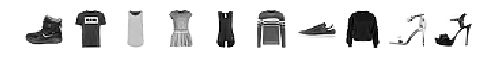

In [3]:
# visualizando algumas imagens de treinamento
n_imgs = 10
for im in np.arange(n_imgs):
  plt.subplot(1,n_imgs,im+1)
  plt.imshow(x_train[im])
  plt.axis('off')

A seguir armazenaremos em variáveis algumas informações importantes como:
- o tamanho das imagens a serem processadas
- o tamanho do *minibatch*, ou seja a quantidade de imagens a serem carregadas em cada iteracao do algoritmo de treinamento da rede neural
- o número de épocas: em uma *época/epoch* o algoritmo utiliza todas as imagens do conjunto de treinamento (por exemplo, para a MNIST significa carregar 60 mil imagens e utilizá-las para treinar a rede)

Além disso a base de dados é reformatada - capturamos o formato pelo pacote "K" de forma a adequar se a imagem é armazenada no formato (linhas x colunas x canais) ou (canais x linhas x colunas)

In [4]:
# capturando o tamanho das imagens da base de dados por meio do 'shape' 
# dos arrays carregados
img_rows, img_cols = x_train.shape[1], x_train.shape[2]

# tamanho do batch por iteracao
batch_size = 32

# número de épocas 
epochs = 8

# número de classes
num_classes = len(np.unique(y_train))

# verifica se as imagens da base de dados tem um canal (i.e. em tons de cinza)
# ou mais do que um canal e se houver mais do que um canal entao armazena a
# quantidade de canais
gray = (len(x_train.shape) == 3)
if (not gray):
  n_channels = x_train.shape[3]
else:
  n_channels = 1 

# re-formatando as imagens de forma que sejam transformadas em 
# matrizes com canais (por exemplo quando as imagens sao RGB)
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], n_channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], n_channels, img_rows, img_cols)
    input_shape = (n_channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, n_channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, n_channels)
    input_shape = (img_rows, img_cols, n_channels)

In [5]:
# os pixels das imagens sao reescalados para melhor processamento
# em particular divide-se por 255 para que os valores fiquem entre 0 e 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
print('Dataset size:')
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convertemos os rótulos numéricos em categóricos
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

Dataset size:
60000 train samples
10000 test samples


### Configuração do modelo de aprendizado

Aqui iremos utilizar o Keras para criar múltiplas camadas, em particular são utilizadas 4 camadas convolucionais e uma densa

- Bloco  convolucional 1:
>- 2 Camadas convolucionais com 16 filtros de tamanho $3\times 3$
>- Camada de redução da dimensionalidade da imagem (por fator 2)
>- Dropout: desligamento de pesos de forma aleatória, com 10% (opcional)

- Bloco convolucional 2:
>- 2 Camadas convolucionais com 32 filtros de tamanho $3\times 3$
>- Camada de redução da dimensionalidade da imagem (por fator 2)
>- Dropout: desligamento de pesos de forma aleatória, com 10% (opcional)


- Camada densa com 32 neurônios
- Dropout: desligamento de pesos de forma aleatória, com 10% (opcional)

- Em todas as camadas a função de ativação utilizada é a 'ReLU'

Para fazer a transição da camada convolucional para a densa é preciso "achatar" (*flatten*) o tensor em um vetor

Por fim uma camada densa de saída é utilizada como classificador:
- Camada densa com 10 neurônios (relativo ao número de classes) e função de ativação do tipo softmax

A função summary mostra as características do modelo

In [7]:
model = tf.keras.Sequential()
# a primeira camada deve informar o tamanho da entrada
model.add(tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 32)        4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
__________

Note como o modelo com camadas convolucionais possui menos parâmetros - esse fato foi um dos motivos de se aumentar a quantidade de camadas convolucionais permitindo a convergência do modelo.

### Compilação e treinamento do modelo
Agora iremos compilar o modelo, definindo:
- A função de custo: utilizamos a entropia cruzada categórica, ou seja, que utiliza rótulos
- O método de otimização:  utilizamos um método baseado no gradiente descendente bastante utilizado conhecido por RMSprop, porém há outros como Adam e AdaGrad e seus parâmetros como a taxa de aprendizado (*learning rate*)
-  As métricas a serem computadas durante o treinamento: além da função de custo em si, automaticamente computada, também vamos armazenar a acurácia

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=0.0025),
              metrics=['accuracy'])


Finalmente, treinamos o método pela função *fit*, que ajusta os parâmetros aos dados rotulados x_train, y_train e utilizando as configurações previamente definidas.

Também informamos quais são os dados de validação. A opção *verbose* exibe os detalhes do processo de treinamento na tela

In [9]:
# a variável history guarda os dados do processo de treinamento para
# posteriormente analisarmos
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
44032/60000 [=====================>........] - ETA: 20s - loss: 0.5717 - acc: 0.7913

60000/60000 [==============================] - 79s 1ms/step - loss: 0.5247 - acc: 0.8090 - val_loss: 0.4509 - val_acc: 0.8416
Epoch 2/8
22144/60000 [==========>...................] - ETA: 49s - loss: 0.3686 - acc: 0.8692

60000/60000 [==============================] - 84s 1ms/step - loss: 0.3602 - acc: 0.8710 - val_loss: 0.3345 - val_acc: 0.8857
Epoch 3/8
12416/60000 [=====>........................] - ETA: 1:01 - loss: 0.3424 - acc: 0.8773

60000/60000 [==============================] - 80s 1ms/step - loss: 0.3417 - acc: 0.8795 - val_loss: 0.3413 - val_acc: 0.8870
Epoch 4/8
10400/60000 [====>.........................] - ETA: 1:03 - loss: 0.3273 - acc: 0.8843

60000/60000 [==============================] - 80s 1ms/step - loss: 0.3309 - acc: 0.8840 - val_loss: 0.3064 - val_acc: 0.8968
Epoch 5/8
 9824/60000 [===>..........................] - ETA: 1:04 - loss: 0.3175 - acc: 0.8902

60000/60000 [==============================] - 80s 1ms/step - loss: 0.3366 - acc: 0.8833 - val_loss: 0.3485 - val_acc: 0.8828
Epoch 6/8
 9408/60000 [===>..........................] - ETA: 1:04 - loss: 0.3352 - acc: 0.8855

60000/60000 [==============================] - 80s 1ms/step - loss: 0.3371 - acc: 0.8840 - val_loss: 0.3592 - val_acc: 0.8831
Epoch 7/8
 9376/60000 [===>..........................] - ETA: 1:04 - loss: 0.3444 - acc: 0.8824

60000/60000 [==============================] - 80s 1ms/step - loss: 0.3446 - acc: 0.8827 - val_loss: 0.3881 - val_acc: 0.8814
Epoch 8/8
 9312/60000 [===>..........................] - ETA: 1:04 - loss: 0.3314 - acc: 0.8791

60000/60000 [==============================] - 80s 1ms/step - loss: 0.3505 - acc: 0.8792 - val_loss: 0.3910 - val_acc: 0.8665


### Avaliação do modelo
Com o modelo já treinado, podemos agora avaliar o seu desempenho, tanto no conjunto de treinamento quanto no conjunto de testes

In [10]:
# avalia as métricas no conjunto de teste
metrics = model.evaluate(x_test, y_test, verbose=0)

# cada métrica é armazenada em uma posicao do vetor
print('Test loss: %.4f' % (metrics[0]))
print('Test accuracy: %.4f' % (metrics[1]))

Test loss: 0.3910
Test accuracy: 0.8665


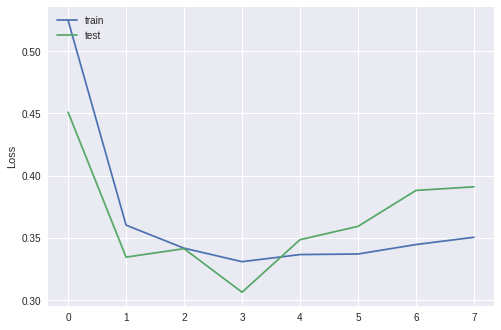

In [11]:
# utilizando o histórico: o gráfico da função de custo ao longo das épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

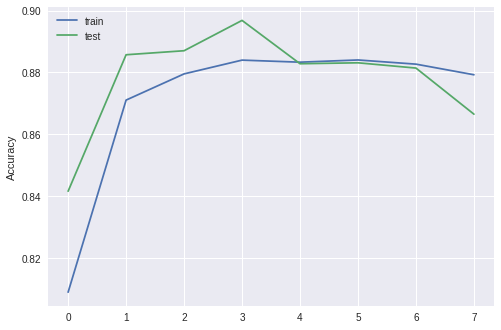

In [12]:
# utilizando o histórico: o gráfico da acurácia ao longo das épocas
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Agora podemos também classificar todos os exemplos de teste e visualizar os resultados de acordo com os rótulos

In [13]:
# obtem as predicoes
y_hat = model.predict(x_test)

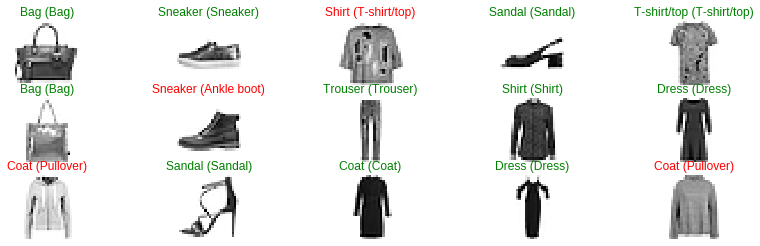

In [14]:
# define os rotulos para visualizacao
mnist_labels = np.arange(10)

fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer", 
                  "dog", "frog", "horse", "ship", "truck"]

# mude aqui para o dataset desejado
use_labels = fashion_mnist_labels

figure = plt.figure(figsize=(14, 4))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # exibe cada imagem
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # exibe o titulo em verde (correto) e vermelho (incorreto)
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))